In [2]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import fft 
import cv2 

np.random.RandomState(73)

RandomState(MT19937) at 0x2D542C21340

In [3]:
def graph_field(campo, title, label):
    """
    Input:
        field: np.array with values of the amplitude of the field in every point
    Output:
        shows the image
    """

    plt.imshow(campo,  cmap='gray')
    plt.colorbar(label=label)
    plt.title(f'Campo de {title}')
    # plt.show()

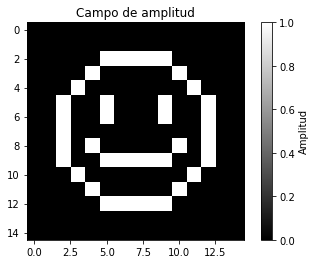

In [4]:
# El campo óptico tendra el comportamiento de una onda plana que sale del objeto con una amplitud constante
campo = np.zeros((15,15))

# Objeto de muestra
objeto = np.array([
       [0, 0, 0, 1, 1, 1, 1, 1, 0, 0, 0],
       [0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0],
       [0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0],
       [1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1],
       [1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1],
       [1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1],
       [1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1],
       [1, 0, 0, 1, 1, 1, 1, 1, 0, 0, 1],
       [0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0],
       [0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0],
       [0, 0, 0, 1, 1, 1, 1, 1, 0, 0, 0]])

# Crear el campo relacionado al objeto
campo[2:13, 2:13] = objeto

# mostrar la información del campo
graph_field(campo, 'amplitud', 'Amplitud')
plt.show()

# Construcción del algoritmo

1) Se define una amplitud objetivo con dimensiones $X \times Y$, que contiene un objeto de dimensiones $L_x  \times L_y$, separado a una distancia $w_x$ del centro


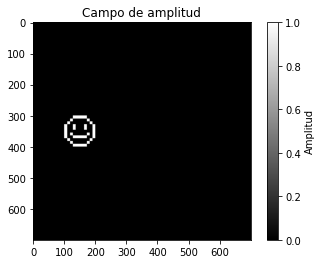

In [5]:
class parameters:
    size_campo = (700, 700)
    len_campo = 700
    size_objecto = (100, 100)
    len_objeto = 100
    amplitud = 1
    Wx = 200

    
# Crear campo óptico 
campo_amplitud = np.zeros(parameters.size_campo)
objeto = cv2.resize(objeto, (100, 100), interpolation=cv2.INTER_NEAREST) 
# objeto = np.ones(parameters.size_objecto)

# Instertar objeto en el campo 
campo_amplitud[300 : 300 +parameters.len_objeto, 300 - parameters.Wx: 300-parameters.Wx + parameters.len_objeto] = objeto

graph_field(campo_amplitud, 'amplitud', 'Amplitud')


2) La amplitud objetivo se multiplica por una máscara de fase aleatoria

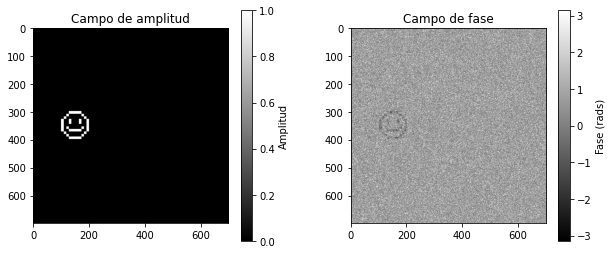

In [6]:

random_phase = np.random.rand(parameters.len_campo, parameters.len_campo) * 2 * np.pi # máscara de fase aleatoria (rads)
complex_phase_mask = np.exp(1j*random_phase)

# Crear el campo óptico g(x,y)  = A(x,y) * e ^(j * phi(x, y))
campo_optico = campo_amplitud * complex_phase_mask

# Graph campo de intensidad y fase del campo
plt.subplot(1, 2, 1)
graph_field(campo_amplitud, 'amplitud', 'Amplitud')

plt.subplot(1, 2, 2)
graph_field(np.angle(campo_optico), 'fase', 'Fase (rads)')

plt.subplots_adjust(left=0, right=1.3, top=0.9, bottom=0.1, wspace=0.3, hspace=0.4)
plt.show()

3) Se aplica una transformadad de Fourier inversa IFT para calcular el campo óptico en el plano del holograma

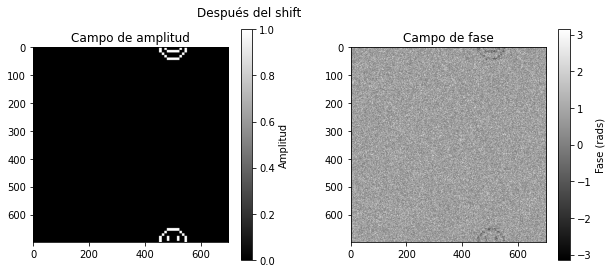

In [7]:
# shifteo del campo óptico 
campo_shift =  fft.ifftshift(campo_optico)

plt.subplot(1, 2, 1)
graph_field(np.abs(campo_shift), 'amplitud', 'Amplitud')

plt.subplot(1, 2, 2)
graph_field(np.angle(campo_shift), 'fase', 'Fase (rads)')

plt.suptitle('Después del shift')
plt.subplots_adjust(left=0, right=1.3, top=0.9, bottom=0.1, wspace=0.3, hspace=0.4)
plt.show()

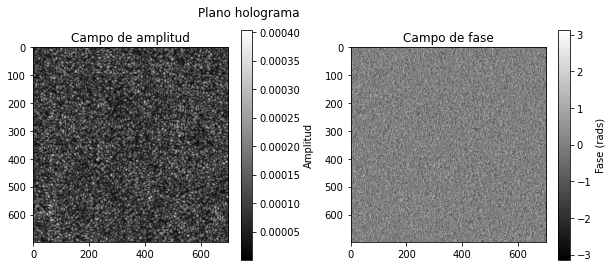

In [8]:
# Campo optico en el plano del holograma

transf_campo =  fft.ifft2(campo_shift)

plt.suptitle('Plano holograma')

plt.subplot(1, 2, 1)
graph_field(np.abs(transf_campo), 'amplitud', 'Amplitud')

plt.subplot(1, 2, 2)
graph_field(np.angle(transf_campo), 'fase', 'Fase (rads)')

plt.subplots_adjust(left=0, right=1.3, top=0.9, bottom=0.1, wspace=0.3, hspace=0.4)
plt.show()


4) Se extrae la información de fase del resultado
5) Se binariza el resultado mediante la ecuación del umbral global dada por la ec. (1), generando así el BAH
$$ B(x) =  \left\{ \begin{array}{lcc} 0 & si & 0  \le angle(POH) \le\pi \\ \\ 1 & si & \pi < angle(POH)\leq 2\pi  \end{array} \right.

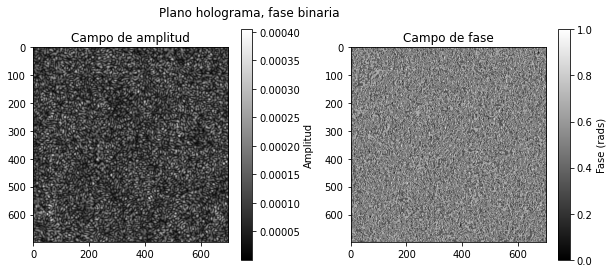

In [9]:
fase = np.angle(transf_campo)
fase = np.mod(fase, 2*np.pi) # Shift angles to [0, 2Pi)

# Función de binarización
B = np.vectorize( lambda x: 0 if (0<x<=np.pi) else (1 if  np.pi < x < 2*np.pi else x) ) 

binnary_phase = B(fase)

plt.suptitle('Plano holograma, fase binaria')

plt.subplot(1, 2, 1)
graph_field(np.abs(transf_campo), 'amplitud', 'Amplitud')

plt.subplot(1, 2, 2)
graph_field(binnary_phase, 'fase', 'Fase (rads)')

plt.subplots_adjust(left=0, right=1.3, top=0.9, bottom=0.1, wspace=0.3, hspace=0.4)
plt.show()

6) Reconstrucción


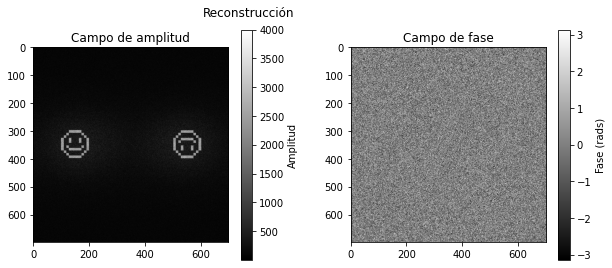

In [10]:
itrans_campo_bin = np.abs(transf_campo) * np.exp(1j  * binnary_phase) # Reconstruido con la fase binaria

# Convertir fase en un objeto de amplitudes
reconstruir_shift = fft.fftshift(binnary_phase)
campo_reconstruido = fft.ifftshift(fft.fft2( reconstruir_shift))

maximo = 4000
cota = np.vectorize(lambda x: x if x < maximo else maximo)

plt.suptitle('Reconstrucción')

plt.subplot(1, 2, 1)
graph_field(cota(np.abs(campo_reconstruido)), 'amplitud', 'Amplitud')
# graph_field(cota(np.abs(campo_reconstruido)), 'amplitud', 'Amplitud')

plt.subplot(1, 2, 2)
graph_field(np.angle(campo_reconstruido), 'fase', 'Fase (rads)')

plt.subplots_adjust(left=0, right=1.3, top=0.9, bottom=0.1, wspace=0.3, hspace=0.4)
plt.show()

# Custom images


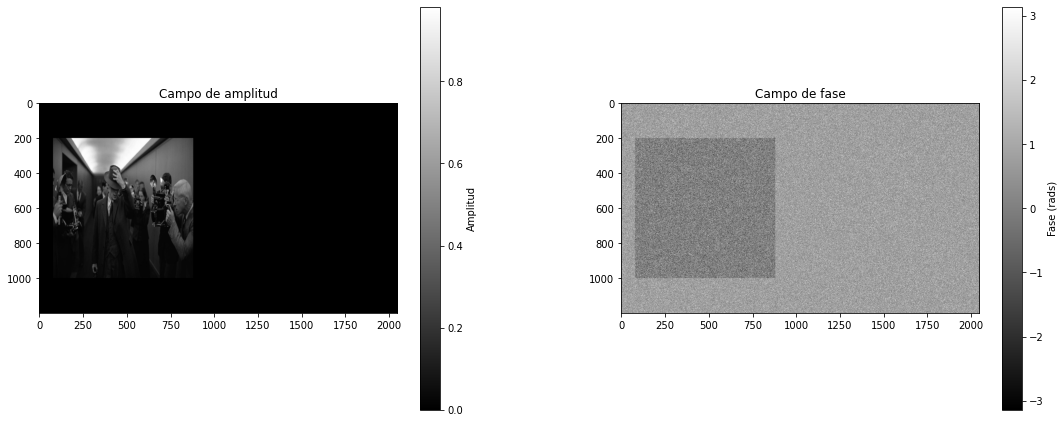

In [11]:
import cv2
from scipy import fft 

class parameters:
    image_path = 'imagenes/image_4.jpg'  # -- Path of the image  here --
    image_size = (800, 800)
    resolution = (1200, 2048)
    sep = 80

def field_from_image(img_path, resolution, object_size, sep):

    # -- read image --

    img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)/255
    img = cv2.resize(img, object_size)
    
    # -- Create optic field --
    campo = np.zeros(resolution)
    
    # Shape the object in the optic field
    aux_y = int( (resolution[0] - object_size[0])/2  )
    aux_x = int( (resolution[1] - object_size[1])  )

    campo[aux_y: resolution[0]-aux_y, sep: sep+ object_size[0]] = img

    # -- Add random phase mask --
    random_phase = np.random.rand(resolution[0], resolution[1]) * 2 * np.pi # máscara de fase aleatoria (rads)
    complex_phase_mask = np.exp(1j*random_phase)

    campo_optico = campo * complex_phase_mask
    
    return campo_optico

    
campo = field_from_image(parameters.image_path, parameters.resolution, parameters.image_size, parameters.sep)

plt.figure(figsize=(11, 7))
plt.subplot(1, 2, 1)
graph_field(np.abs(campo), 'amplitud', 'Amplitud')

plt.subplot(1, 2, 2)
graph_field(np.angle(campo), 'fase', 'Fase (rads)')

plt.subplots_adjust(left=0, right=1.3, top=0.9, bottom=0.1, wspace=0.3, hspace=0.4)
plt.show()

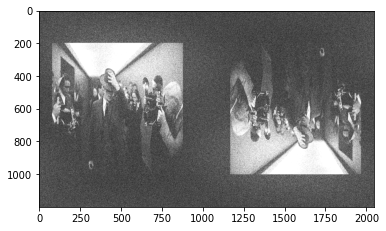

In [16]:
# Función de binarización
B = np.vectorize( lambda x: 0 if (0<x<=np.pi) else (1 if  np.pi < x < 2*np.pi else x) ) 

def BAH(campo, filter=1300):

    # -- Shift field --
    campo_shift =  fft.ifftshift(campo)
    # -- IFT --
    trans_campo =  fft.ifft2(campo_shift)
    
    # -- Binary phase --
    fase = np.angle(trans_campo)
    fase = np.mod(fase, 2*np.pi) # Shift angles to [0, 2Pi)
    binnary_phase = B(fase)

    
    # -- TF to binnary_phases --
    reconstruir_shift = fft.fftshift(binnary_phase)
    campo_reconstruido = fft.ifftshift(fft.fft2( reconstruir_shift))

    # Add filter, try with the best value
    
    cota = np.vectorize(lambda x: x if x < filter else filter)
    cv2.imwrite('imagenes/copia.bmp', binnary_phase*255)

    # -- Normalice image --
    img  = cota(np.abs(campo_reconstruido))
    img = img / img.max() * 255
    cv2.imwrite('imagenes/copia.bmp', img)

    # return binnary_phase*255
    return img
plt.imshow(BAH(campo), cmap='gray')